In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, OrdinalEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [26]:
#load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (1913, 14)
Test shape: (479, 13)


In [27]:
#data info
print("\nTrain Head:")
train.head()


Train Head:


,participant_id,age_group,identity_code,cultural_background,upbringing_influence,focus_intensity,consistency_score,external_guidance_usage,support_environment_score,hobby_engagement_level,physical_activity_index,creative_expression_index,altruism_score,personality_cluster
0,643,18,1,0,4,18.118879,24,1,0,1,1,0,0,Cluster_E
1,1753,16,1,3,2,2.469271,19,0,1,0,0,0,1,Cluster_E
2,1402,17,0,2,3,3.456401,25,0,0,0,0,0,0,Cluster_E
3,2033,17,1,0,1,15.838131,25,1,2,0,0,0,0,Cluster_E
4,991,16,0,0,0,1.045373,19,1,2,0,0,1,0,Cluster_E


In [28]:
#check for negatives in training data
numeric_cols=train.select_dtypes('number').columns.tolist()
print("\nAny negative numeric values per column:")
print((train[numeric_cols]<0).any())


Any negative numeric values per column:
participant_id               False
age_group                    False
identity_code                False
cultural_background          False
upbringing_influence         False
focus_intensity              False
consistency_score            False
external_guidance_usage      False
support_environment_score    False
hobby_engagement_level       False
physical_activity_index      False
creative_expression_index    False
altruism_score               False
dtype: bool


In [29]:
#check for duplicates
dup_count = train.duplicated().sum()
print(f"\nNumber of duplicate rows in train: {dup_count}")

if dup_count > 0:
    train.drop_duplicates(inplace=True)
    print("Duplicates removed. New shape:", train.shape)


Number of duplicate rows in train: 0


In [30]:
#check for missing vals
print("\nMissing Values in Train Dataset:")
print(train.isnull().sum())


Missing Values in Train Dataset:
participant_id               0
age_group                    0
identity_code                0
cultural_background          0
upbringing_influence         0
focus_intensity              0
consistency_score            0
external_guidance_usage      0
support_environment_score    0
hobby_engagement_level       0
physical_activity_index      0
creative_expression_index    0
altruism_score               0
personality_cluster          0
dtype: int64


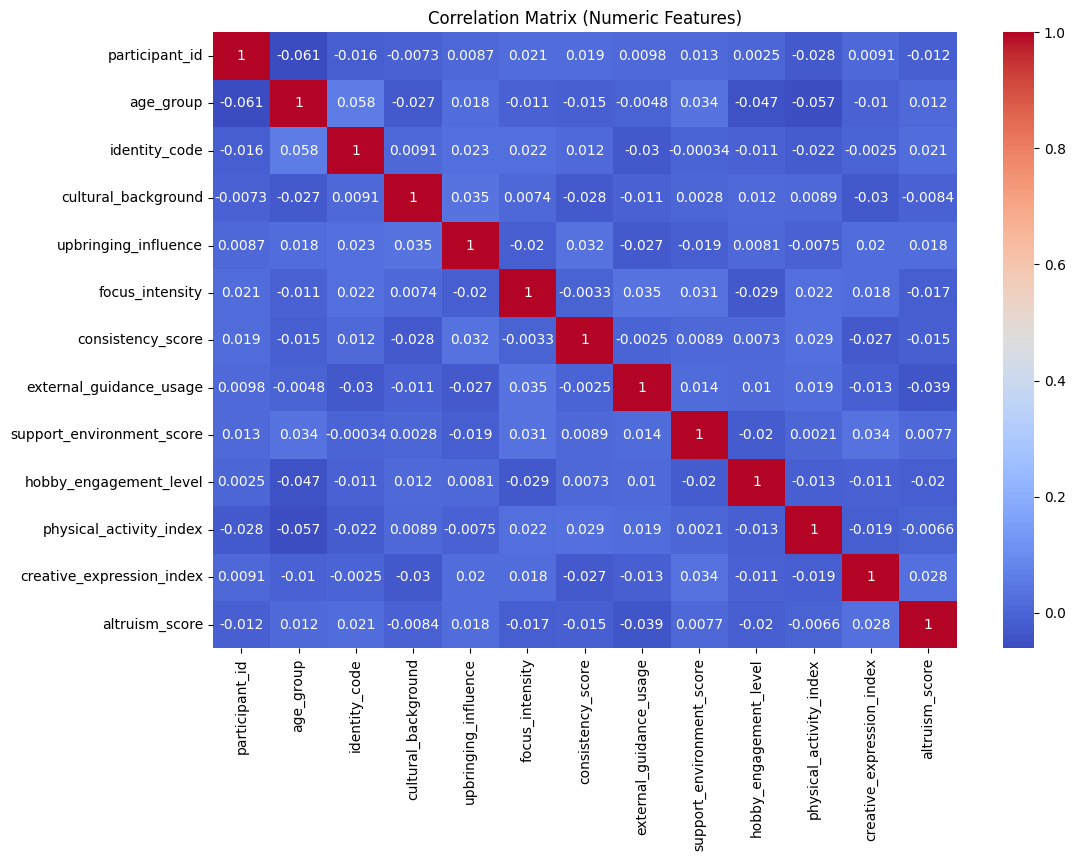

In [31]:
# Correlation Matrix
numeric_features = train.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12,8))
sns.heatmap(train[numeric_features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

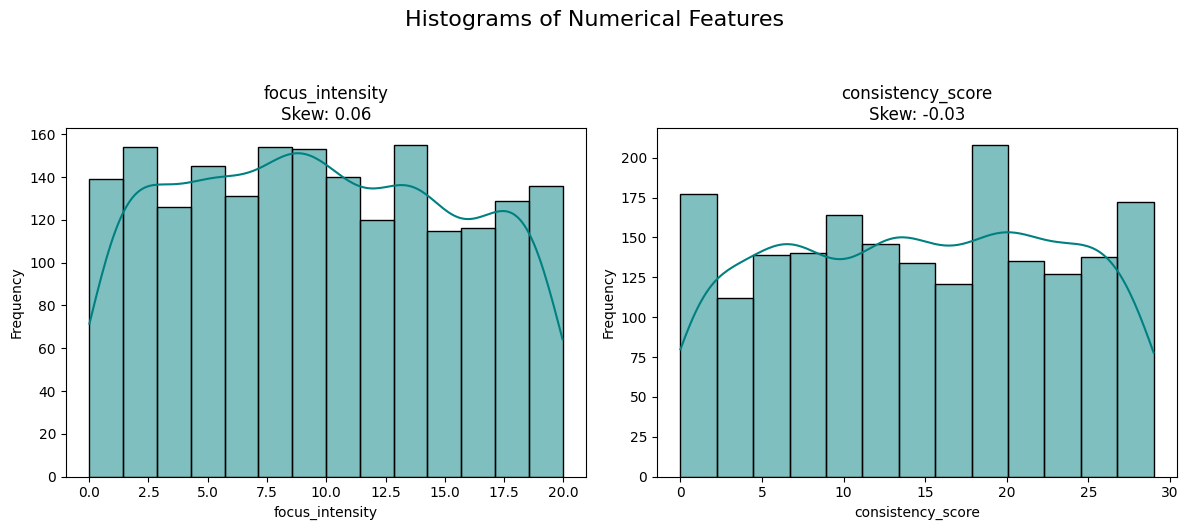

In [32]:
# Feature Distributions (Histograms)
num_cols_for_plot = ['focus_intensity', 'consistency_score']
skew_values = train[num_cols_for_plot].skew().sort_values(ascending=False)
sorted_cols = skew_values.index.tolist()


plt.figure(figsize=(12, 5))
plt.suptitle('Histograms of Numerical Features', y=1.05, fontsize=16)

for i, col in enumerate(sorted_cols, 1):
    plt.subplot(1, 2, i) # Adjusted subplot layout for 2 features
    sns.histplot(train[col].dropna(), kde=True, bins='auto', color='teal')
    plt.title(f'{col}\nSkew: {skew_values[col]:.2f}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.show()

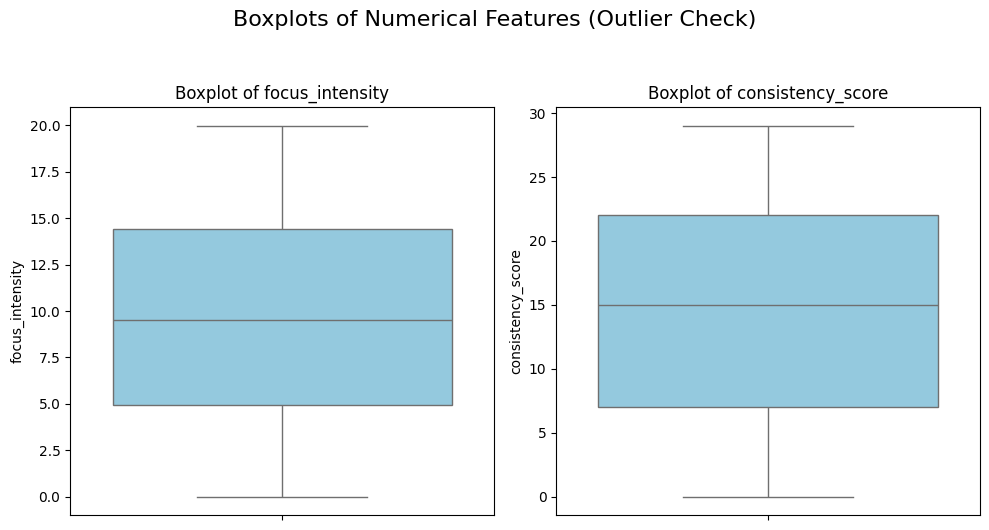

In [33]:
# Box plots for Outlier Detection
plt.figure(figsize=(10, 5))
plt.suptitle('Boxplots of Numerical Features (Outlier Check)', y=1.05, fontsize=16)

for i, col in enumerate(num_cols_for_plot, 1):
    plt.subplot(1, 2, i) # Adjusted subplot layout for 2 features
    # Boxplots are better as vertical plots (y=) for visual inspection
    sns.boxplot(y=train[col], color='skyblue') 
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [34]:
# Separate Features (X) and Target (y)
X = train.drop(columns=['participant_id', 'personality_cluster'])
y = train['personality_cluster']

# Prepare the final test set (drop identifier)
X_test_final = test.drop(columns=['participant_id'])

In [ ]:
# Define Column Types 
numerical_cols = ['focus_intensity', 'consistency_score']
nominal_cols = [
    'identity_code', 'cultural_background', 'upbringing_influence', 
    'external_guidance_usage', 'support_environment_score', 'hobby_engagement_level', 
    'physical_activity_index', 'creative_expression_index', 'altruism_score'
]
ordinal_cols = ['age_group']

In [ ]:
# Create Preprocessing Pipelines
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()) # Scaling the numerical data
])

# FIXED: Use OneHotEncoder for Nominal features
nominal_pipeline = Pipeline(steps=[
    # sparse_output=False makes the output a dense numpy array
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 
])

# Keep OrdinalEncoder for Ordinal features (age_group)
ordinal_pipeline = Pipeline(steps=[
    ('ordinal_encoder', OrdinalEncoder())
])


# 3. Create the Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('nom', nominal_pipeline, nominal_cols), # New Nominal Pipeline
        ('ord', ordinal_pipeline, ordinal_cols)
    ],
    remainder='drop' 
)

print("\n--- Fixed Preprocessor Defined: Nominal features will be One-Hot Encoded ---")


--- Preprocessor Defined ---


In [37]:
# Fit and Transform Data 
X_processed = preprocessor.fit_transform(X)
X_test_final_processed = preprocessor.transform(X_test_final)

In [38]:
# Target Variable Encoding 
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print("Target Variable Mapping (Original -> Encoded):")
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

Target Variable Mapping (Original -> Encoded):
{'Cluster_A': np.int64(0), 'Cluster_B': np.int64(1), 'Cluster_C': np.int64(2), 'Cluster_D': np.int64(3), 'Cluster_E': np.int64(4)}
